<a href="https://colab.research.google.com/github/alirezash97/Cardio/blob/master/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

!pip3 install git+https://github.com/analysiscenter/cardio.git

In [0]:
## PhysioNet 2017 dataset 

!unzip '/content/drive/My Drive/Cardio/training2017.zip'

In [0]:
## HeartBeat dataset 

!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"alirezashafaei97","key":"9cb262aa0c5658ffc4eb45857c41903c"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!mkdir ~/.kaggle
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d shayanfazeli/heartbeat -p /content
!unzip /content/heartbeat.zip -d /content/heartbeat

In [0]:
########## traingng 2017 ########
import sys
import numpy as np
from cardio import EcgBatch
import cardio.batchflow as bf

from matplotlib import pyplot as plt

sys.path.append('/content/training2017')


index = bf.FilesIndex(path='/content/training2017/A*.hea', no_ext=True, sort=True)

eds = bf.Dataset(index, batch_class=EcgBatch)

batch = eds.next_batch(batch_size=8528, unique_labels=['A', 'N', 'O', '~'])

batch_with_data = batch.load(fmt='wfdb', components=['signal', 'meta'])

batch_with_data = batch_with_data.load(src='/content/training2017/REFERENCE.csv', fmt='csv', components='target')



(1, 18000)
N
[[-0.497 -0.633 -0.775 ... -0.01  -0.028 -0.04 ]]


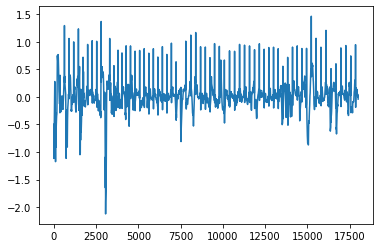

In [7]:
print(batch_with_data['A04211'].signal.shape)
print(batch_with_data['A04211'].target)
print(batch_with_data['A04211'].signal)
plt.plot(batch_with_data['A04211'].signal[0])
plt.show()

In [0]:
## heartbeat dataset 
import pywt
import pandas as pd


test_df=pd.read_csv('/content/heartbeat/mitbih_test.csv',header=None)

X_test=test_df.iloc[:,:186].values
target_test=test_df[187]



XF_test = np.zeros((X_test.shape[0], 9000))
for index, row in enumerate(X_test):
  XF_test[index, :] = pywt.pad(row, 4407, 'periodic')



In [10]:
print(target_test.shape)
print(XF_test.shape)

(21892,)
(21892, 9000)


In [11]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model


# load model
model = load_model('/content/drive/My Drive/Cardio/HeartBeat.h5')

# summarize model.
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2999, 64)     384         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 2999, 64)     36928       conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2999, 64)     256         conv1d_1[0][0]                   
______________________________________________________________________________________________

In [38]:
sample1 = XF_test[21000:21001, :]
truth_value1 = target_test[21000:21001]

sample2 = XF_test[20000:20001, :]
truth_value2 = target_test[20000:20001]

sample3 = XF_test[18500:18501, :]
truth_value3 = target_test[18500:18501]

final_samples = np.zeros((3, sample1.shape[1]))
final_samples[:1, :] = sample1 
final_samples[1:2, :] = sample2
final_samples[2:3, :] = sample3  


predicted_values = model.predict(final_samples)
predicted = []
for predict in predicted_values :
  result = np.where(predict == np.amax(predict))
  predicted.append(result[0])

print(predicted)
print(truth_value1,"\n", truth_value2,"\n", truth_value3)


[array([4]), array([2]), array([1])]
[4.] 
 20000    2.0
Name: 187, dtype: float64 
 18500    1.0
Name: 187, dtype: float64


In [0]:
signal = sample1[0]
signal1 = signal[125:300]
pre0 = int(predicted[0])
true0 = int(truth_value1.values)


signal = sample2[0]
signal2 = signal[125:300]
pre1 = int(predicted[1])
true1 = int(truth_value2.values)

signal = sample3[0]
signal3 = signal[125:300]
pre2 = int(predicted[2])
true2 = int(truth_value3.values)


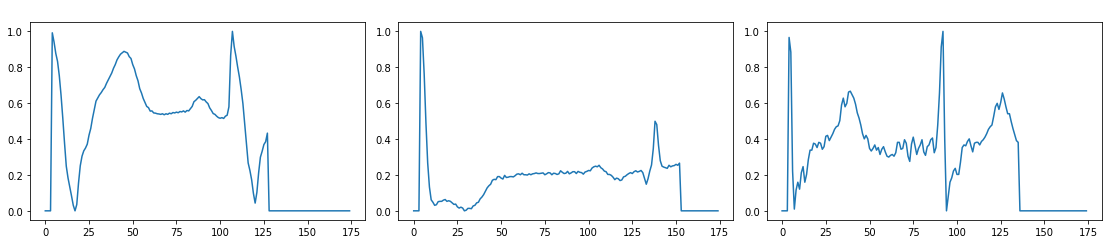

In [69]:
fig, axs = plt.subplots(1, 3)
axs[0].plot(signal1)
axs[0].set_title('predicted category '+str(pre0)+', true category '+str(true0), color='w')
axs[1].plot(signal2)
axs[1].set_title('predicted category '+str(pre1)+', true category '+str(true1), color='w')
axs[2].plot(signal3)
axs[2].set_title('predicted category '+str(pre2)+', true category '+str(true2), color='w')
fig.set_size_inches(15.5, 3.5)
fig.tight_layout()
plt.savefig('signals.png')

In [70]:
# load model
model = load_model('/content/drive/My Drive/Cardio/AF_Classification.h5')

# summarize model.
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 9000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 4498, 16)     96          input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_52 (Conv1D)              (None, 4498, 32)     4640        conv1d_51[0][0]                  
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 4498, 32)     128         conv1d_52[0][0]                  
____________________________________________________________________________________________

In [71]:
import random

Augmented = 0
dataset = np.zeros((15000, 9001))
pointer = 0
for ecg in batch_with_data:
  
  if ecg.target == 'A' or ecg.target == 'O' or ecg.target == 'N' or ecg.target == '~' : 
    if ecg.signal.shape[1] == 18000:
        
        dataset[pointer:pointer+1, :9000] = ecg.signal[:1, :9000]

        ### pointer+2 for next slice ###

        if ecg.target == 'A':
          dataset[pointer:pointer+2, 9000:9001] = 0
        elif ecg.target == 'N':
          dataset[pointer:pointer+2, 9000:9001] = 1
        elif ecg.target == 'O':
          dataset[pointer:pointer+2, 9000:9001] = 2
        elif ecg.target == '~':
          dataset[pointer:pointer+2, 9000:9001] = 3
        
        pointer += 1 
          
        ###### next slice ######

        
        dataset[pointer:pointer+1, :9000] = ecg.signal[:1, 9000:18000]
        pointer += 1 
        
        ## target column is already filled ##

    elif ecg.signal.shape[1] == 9000:
        
        dataset[pointer:pointer+1, :9000] = ecg.signal[:1, :9000]


        if ecg.target == 'A':
          dataset[pointer:pointer+1, 9000:9001] = 0
        elif ecg.target == 'N':
          dataset[pointer:pointer+1, 9000:9001] = 1
        elif ecg.target == 'O':
          dataset[pointer:pointer+1, 9000:9001] = 2
        elif ecg.target == '~':
          dataset[pointer:pointer+2, 9000:9001] = 3
        
        pointer += 1

    elif ecg.signal.shape[1] > 9000 and ecg.signal.shape[1] != 18000:
      
      
      dataset[pointer:pointer+1, :9000] = ecg.signal[:1, :9000]
      

      if ecg.target == 'A':
        dataset[pointer:pointer+1, 9000:9001] = 0
      elif ecg.target == 'N':
        dataset[pointer:pointer+1, 9000:9001] = 1
      elif ecg.target == 'O':
        dataset[pointer:pointer+1, 9000:9001] = 2
      elif ecg.target == '~':
        dataset[pointer:pointer+2, 9000:9001] = 3
        
        pointer += 1

    #### data augmentation ######



    # if ecg.signal.shape[1] >= 9000:
    #   chance = 0.0   # not now, this is for both training and test
    #   rand_num = random.uniform(0, 1)
        
    #   if chance > rand_num :

          
    #     noise = np.random.normal(0,0.05,9000)
    #     new_signal = ecg.signal[:1, :9000] + noise  
    #     dataset[pointer:pointer+1, :9000] = new_signal



    #     if ecg.target == 'A':
    #       dataset[pointer:pointer+1, 9000:9001] = 0
    #     elif ecg.target == 'N':
    #       dataset[pointer:pointer+1, 9000:9001] = 1
    #     elif ecg.target == 'O':
    #       dataset[pointer:pointer+1, 9000:9001] = 2
    #     elif ecg.target == '~':
    #       dataset[pointer:pointer+2, 9000:9001] = 3
        
    #     pointer += 1
    #     Augmented += 1

    ################################

    else: 
      pass

  else:
    pass



print(Augmented)

0


In [0]:
filled = 7608+Augmented
dataset[filled:15000, :]

trainset = np.zeros((filled, 9001))
trainset = dataset[:filled, :]

# some of the signals are skipped because of different dimentions

In [0]:
temp = trainset[:, :]
temp = np.take(temp,np.random.permutation(temp.shape[0]),axis=0,out=temp);
X = temp[:, :-1]
Y = temp[:, -1:].reshape(filled, 1)

In [74]:
print(X.shape)
print(Y.shape)

(7608, 9000)
(7608, 1)


In [77]:
sample1 = X[1000:1001, :]
truth_value1 = Y[1000:1001]

sample2 = X[2200:2201, :]
truth_value2 = Y[2200:2201]

sample3 = X[3850:3851, :]
truth_value3 = Y[3850:3851]

final_samples = np.zeros((3, sample1.shape[1]))
final_samples[:1, :] = sample1 
final_samples[1:2, :] = sample2
final_samples[2:3, :] = sample3  


predicted_values = model.predict(final_samples)
predicted = []
for predict in predicted_values :
  result = np.where(predict == np.amax(predict))
  predicted.append(result[0])

print(predicted)
print(truth_value1,"\n", truth_value2,"\n", truth_value3)

[array([2]), array([0]), array([1])]
[[2.]] 
 [[0.]] 
 [[1.]]


In [0]:
signal = sample1[0]
signal1 = signal[:]
pre0 = int(predicted[0])
true0 = int(truth_value1)


signal = sample2[0]
signal2 = signal[:]
pre1 = int(predicted[1])
true1 = int(truth_value2)

signal = sample3[0]
signal3 = signal[:]
pre2 = int(predicted[2])
true2 = int(truth_value3)


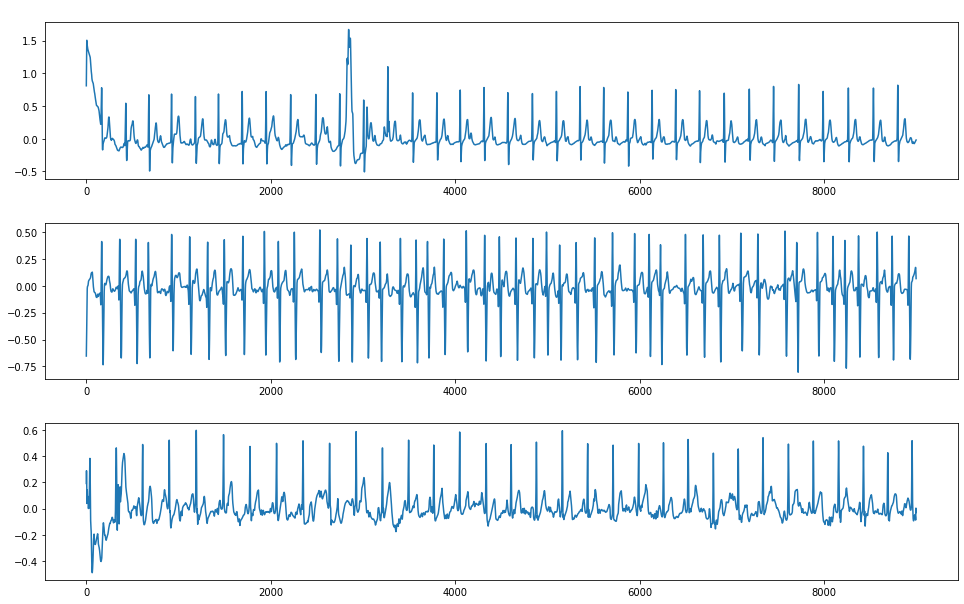

In [88]:
fig, axs = plt.subplots(3, 1)
axs[0].plot(signal1)
axs[0].set_title('predicted category '+str(pre0)+', true category '+str(true0), color='w')
axs[1].plot(signal2)
axs[1].set_title('predicted category '+str(pre1)+', true category '+str(true1), color='w')
axs[2].plot(signal3)
axs[2].set_title('predicted category '+str(pre2)+', true category '+str(true2), color='w')
fig.set_size_inches(13.5, 8.5)
fig.tight_layout()